# This notebook analyzes FVS benchmark results and produces various graphics

In [69]:
#
# Configure these settings to reflect your local setup
#

DATASET="deep1M"

QUERIES_1000="results/benchmarks-%s-q1000.csv" % DATASET

QUERIES_10="results/benchmarks-%s-q10.csv" % DATASET

NUM_APUS=1

MAIN_MEMORY_SIZE = "700G"

PLOT_TITLE="Gemini FVS Benchmarks"

PLOT_SUBTITLE="%s (1M of deep1B), %d APU(s), %s of Host Main Memory" % \
    ( DATASET, NUM_APUS, MAIN_MEMORY_SIZE )

In [41]:
#
# Imports
# 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [42]:
#
# Load all the CSV files into dataframes
#

df_q1000 = pd.read_csv( QUERIES_1000 )
print(df_q1000.shape)

df_q10 = pd.read_csv( QUERIES_10 )
print(df_q10.shape)


(15, 12)
(15, 12)


In [43]:
#
# Combine the dataframes into one
#

# augment with a 'num_queries' column
df_q1000['num_queries']=1000

# augment with a 'num_queries' column
df_q10['num_queries']=10

# combine
df_all = pd.concat([ df_q1000, df_q10 ] )
print(df_all.shape)
print(df_all.columns)

(30, 13)
Index(['allocationid', 'datasetid', 'dataset_path', 'queries_path', 'bits',
       'ts_start', 'ts_train_start', 'ts_train_end', 'ts_query_start',
       'ts_query_end', 'response', 'recall', 'num_queries'],
      dtype='object')


In [44]:
#
# Create throughput column
#

df_all['throughput'] = df_all.apply( \
            lambda row: row['response']/row['num_queries'], axis=1 )
    
print(df_all[["num_queries","bits","response","recall", "throughput"]])

    num_queries  bits  response  recall  throughput
0          1000   768  2.915360  0.9997    0.002915
1          1000   768  2.940215  0.9997    0.002940
2          1000   768  2.875883  0.9997    0.002876
3          1000   512  0.887977  0.9997    0.000888
4          1000   512  0.895868  0.9997    0.000896
5          1000   512  0.886778  0.9997    0.000887
6          1000   256  0.611309  0.9994    0.000611
7          1000   256  0.654820  0.9994    0.000655
8          1000   256  0.603681  0.9994    0.000604
9          1000   128  0.641501  0.9899    0.000642
10         1000   128  0.596934  0.9899    0.000597
11         1000   128  0.591362  0.9899    0.000591
12         1000    64  0.450553  0.9455    0.000451
13         1000    64  0.491143  0.9455    0.000491
14         1000    64  0.492434  0.9455    0.000492
0            10   768  0.020478  1.0000    0.002048
1            10   768  0.017423  1.0000    0.001742
2            10   768  0.018164  1.0000    0.001816
3           

In [53]:
# 
# Grouping rows and then average 'response' and 'throughput'
# 

df_plot = \
    df_all[["num_queries","bits","recall","throughput"]].\
        groupby(['num_queries', 'bits'], as_index=False).mean()
print(df_plot)

   num_queries  bits  recall  throughput
0           10    64  0.9700    0.000751
1           10   128  0.9800    0.001083
2           10   256  1.0000    0.001058
3           10   512  1.0000    0.002100
4           10   768  1.0000    0.001869
5         1000    64  0.9455    0.000478
6         1000   128  0.9899    0.000610
7         1000   256  0.9994    0.000623
8         1000   512  0.9997    0.000890
9         1000   768  0.9997    0.002910


In [54]:
#
# Extract arrays for plotting
#

q1000_recall = list(df_plot.loc[ df_plot['num_queries']==1000 ]["recall"])
q1000_throughput = list(df_plot.loc[ df_plot['num_queries']==1000 ]["throughput"])

q10_recall = list(df_plot.loc[ df_plot['num_queries']==10 ]["recall"])
q10_throughput = list(df_plot.loc[ df_plot['num_queries']==10 ]["throughput"])


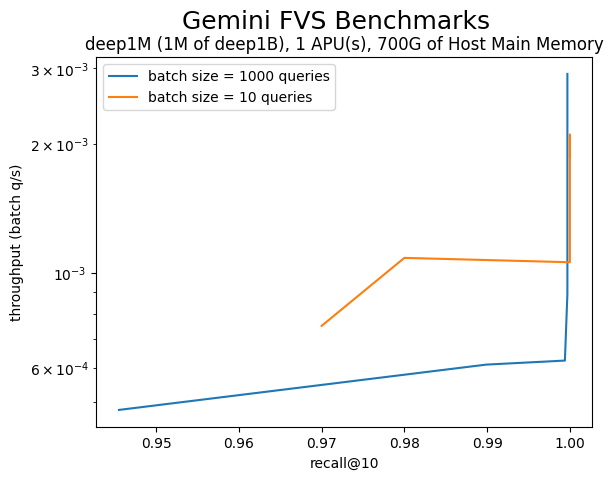

In [70]:
#
# Plot the data
#

plt.plot(q1000_recall, q1000_throughput, label = "batch size = 1000 queries")
plt.plot(q10_recall, q10_throughput, label = "batch size = 10 queries")
plt.legend()
plt.xlabel("recall@10")
plt.ylabel("throughput (batch q/s)")
plt.yscale('log')
plt.suptitle(PLOT_TITLE, fontsize=18)
plt.title(PLOT_SUBTITLE)
plt.savefig("results/gemini_fvs.png")
plt.show()
